# Structure
* [Dataset](#dataset)
* [Linear Regression with scikit-learn](#linear_reg)
* [Linear Regression with PyTorch](#linear_reg_pytorch)

In [2579]:
import os
import glob

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

## <a id='dataset'> Dataset </a>

In [2580]:
dataset = pd.read_csv('ice_cream.csv')

In [2581]:
dataset.columns = [column_name.lower() for column_name in dataset.columns]

In [2582]:
X = minmax_scale(X=dataset.drop(columns=["revenue"]))
y = dataset["revenue"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2583]:
def get_corr_coef(data: pd.DataFrame, feature_1: str, feature_2: str) -> float:
    corr_coef = data[[feature_1, feature_2]].corr(method='kendall')
    corr_coef = corr_coef[feature_1][feature_2]

    return corr_coef

def show_correlation(data: pd.DataFrame, feature_1: str, feature_2: str):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[feature_1], data[feature_2], color='blue', marker='o')
    plt.title(f"{feature_1} vs {feature_2}")
    plt.ylabel(feature_2)
    plt.xlabel(feature_1)
    plt.grid(True)
    plt.show()

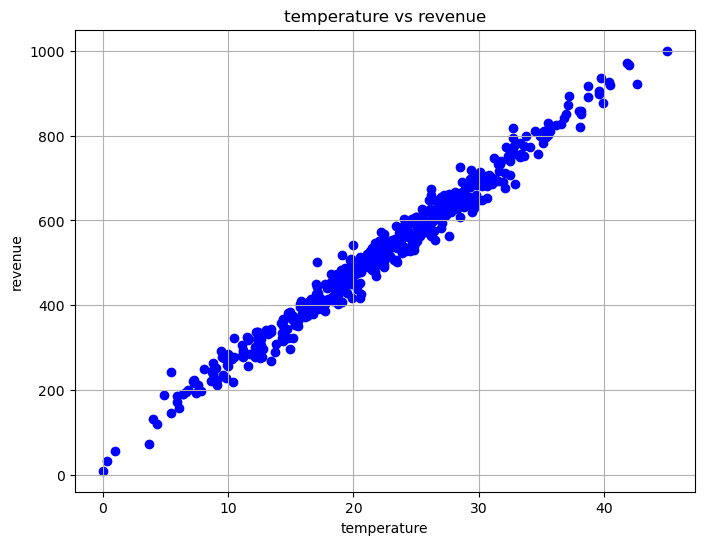

Correlation coefficient for temperature and revenue: 0.9122147585944843


In [2584]:
show_correlation(data=dataset, feature_1="temperature", feature_2="revenue")
corr_coef = get_corr_coef(data=dataset, feature_1="temperature", feature_2="revenue")
print(f"Correlation coefficient for temperature and revenue: {corr_coef}")

#### Based on correlation coefficient and scatter plot we can notice strong correlation between `temperature` and `revenue`
#### We also can see that there are no "strong" outliers that is data is dense

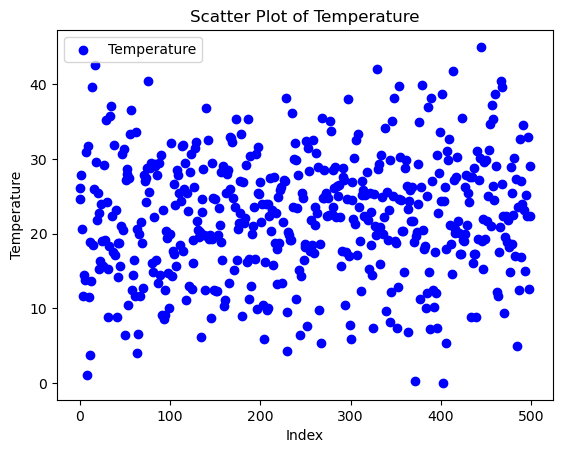

In [2585]:
plt.scatter(dataset.index, dataset['temperature'], color='blue', label='Temperature')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Scatter Plot of Temperature')
plt.legend()
plt.show()

## <a id='linear_reg'>Linear Regression with scikit-learn</a>

### Ordinary least squares Linear Regression.

In [2586]:
# Train model
reg = LinearRegression().fit(X_train, y_train)

In [2587]:
reg_coef = reg.coef_[0]
reg_intercept = reg.intercept_

print(f"Linear Regression coefficient is: {reg_coef}\nLinear Regression intercept is: {reg_intercept}")

Linear Regression coefficient is: 963.9751982399548
Linear Regression intercept is: 45.06352623099809


In [2588]:
def graph(formula, x_range: np.ndarray, X: np.ndarray, y: pd.Series, intercept: float, coef: float):  
    x = np.array(x_range)  
    y_formula = formula(x, intercept=intercept, coef=coef)  
    plt.plot(x, y_formula)  
    plt.scatter(X, y, color='red', label='Data')
    
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()

def my_formula(x: np.ndarray, intercept: float, coef: float):
    return coef * x + intercept

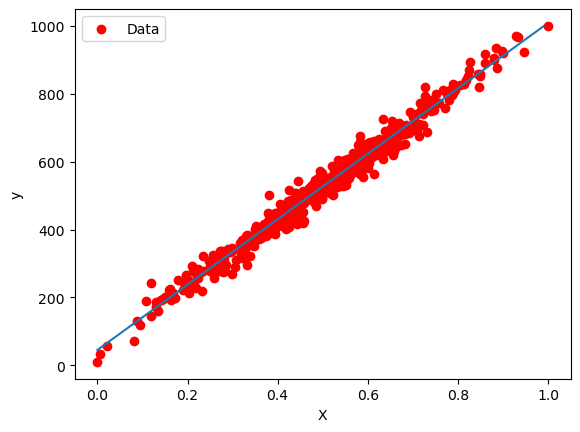

In [2589]:
x_range = np.arange(X.min(), X.max(), 0.01)
graph(my_formula, x_range,  X, y, intercept=reg_intercept, coef=reg_coef)

#### There is really strong correlation so it's not suprising results of the model.

### Linear model fitted by minimizing a regularized empirical loss with SGD.

In [2590]:
criterion = 'squared_error'
penalty = None
random_state = 9
early_stopping = True

learning_rates = ["constant", "optimal", "invscaling", "adaptive"]
n_iters_no_change = [2, 5, 10]
eta0s = [0.01, 0.09, 0.2, 0.7, 0.9]

In [2591]:
best_params = {}
ites = 0
for learning_rate in learning_rates:
    for n_iter_no_change in n_iters_no_change:
        for eta0 in eta0s:
            ites += 1
            regressor = SGDRegressor(
                loss=criterion,
                penalty=penalty,
                random_state=random_state,
                early_stopping=early_stopping,
                learning_rate=learning_rate,
                n_iter_no_change=n_iter_no_change,
                eta0=eta0
            )

            regressor.fit(X_train, y_train)

            score = regressor.score(X_test, y_test)

            if not best_params:
                best_params = {
                    "bias": regressor.intercept_,
                    "weight": regressor.coef_,
                    "score": score,
                    "learning_rate": learning_rate,
                    "n_iter_no_change": n_iter_no_change,
                    "eta0": eta0
                }
            else:
                prev_score = best_params["score"]
                if score > prev_score:
                    best_params = {
                    "bias": regressor.intercept_,
                    "weight": regressor.coef_,
                    "score": score,
                    "learning_rate": learning_rate,
                    "n_iter_no_change": n_iter_no_change,
                    "eta0": eta0
                }

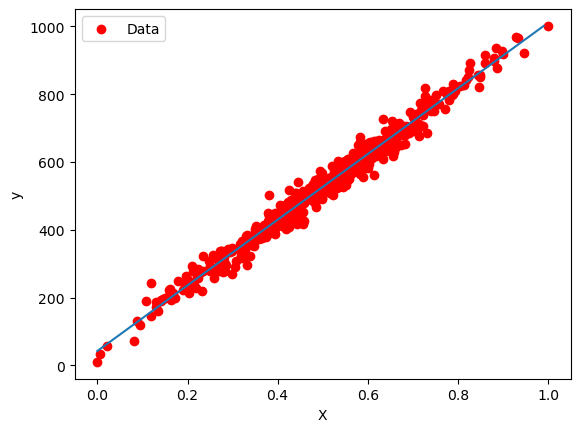

{'bias': array([42.20098102]),
 'weight': array([968.95685572]),
 'score': 0.9799430004729222,
 'learning_rate': 'adaptive',
 'n_iter_no_change': 2,
 'eta0': 0.2}

In [2592]:
graph(my_formula, x_range,  X, y, best_params["bias"][0], best_params["weight"][0])
best_params

## <a id='linear_reg_pytorch'>Linear Regression with PyTorch</a>

In [2593]:
def set_seed(seed):
    """
    The function that sets a random seed to ensure the reproducibility of any randomized processes
    """

    np.random.seed(seed)
    torch.manual_seed(seed)


# Model
class LinearRegression_torch(nn.Module):
    """
    Linear Regression model (single neuron Neural Network)
    """

    def __init__(self, in_dim, out_dim):
        super(LinearRegression_torch, self).__init__()

        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        output = self.linear(x)
        return output

In [2594]:
x_train_torch = torch.from_numpy(X_train.astype(np.float32)).reshape(350)
y_train_torch = torch.from_numpy(y_train.astype(np.float32))
x_test_torch = torch.from_numpy(X_test.astype(np.float32)).reshape(150)
y_test_torch = torch.from_numpy(y_test.astype(np.float32))

train = TensorDataset(x_train_torch, y_train_torch)
test = TensorDataset(x_test_torch, y_test_torch)
train_loader = DataLoader(dataset = train, batch_size = 100, shuffle = True)
test_loader = DataLoader(dataset = test, batch_size = 100, shuffle = True)



In [2595]:
# Setup of random seed (DO NOT CHANGE)
set_seed(9)

# Initialization of Model, Cost function and Optimizer

# Input & Output Dimensions of the Model (DO NOT CHANGE)
# input dimension = n of features in dataset
# output dimension = n of desired outputs (we want to predict only 1 value)
in_dim, out_dim = 1, 1 # input and output dimensions of the Model

# Learning Rate
# Figured out manually
lr  = 50
# n of iterations of Optimizer
# epochs = [10, 20, 50, 100]
epochs = [40, 10, 5]

# Model
# model = LinearRegression_torch(in_dim, out_dim)

# Cost Function
criterion = nn.MSELoss()

# Folder where we store model states
model_states_dir = "./model_states/"


In [2596]:
optimizers = {
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop
}

In [2597]:
def plot_metrics(epochs: int, metric_1: list, metric_2: list, optimizer: str):
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), metric_1, label='Training Loss')
    plt.plot(range(epochs), metric_2, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"Training and Validation Loss over Epochs via {optimizer}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [2598]:
def train_cycle(optimizer, model: LinearRegression_torch, epochs: int, model_name: str, prev_epochs: int):
    set_seed(9)

    train_metrics = []
    test_metrics = []

    for epoch in range(epochs):

        ### Training ###
        train_loss = []
        model.train()

        for i, (x_tr, y_tr) in enumerate(train_loader):

            # Compute predictions
            outputs = model(x_tr.reshape(-1, 1))
            # Compute Loss for predictions
            loss = criterion(outputs, y_tr.reshape(-1, 1))
            # Remove previous gradients
            optimizer.zero_grad()
            # Compute current gradients
            loss.backward()
            # Update parameters
            optimizer.step()
            # Save training Loss
            train_loss.append(loss.item())

        # Get mean Training Loss per epoch
        train_mean_loss = sum(train_loss) / len(train_loss)
        train_metrics.append(train_mean_loss)

        ### Validation ###
        test_loss = []
        model.eval()

        with torch.no_grad():
            for x_ts, y_ts in test_loader:

                # Compute predictions
                outputs = model(x_ts.reshape(-1, 1))
                # Compute Loss for predictions
                loss = criterion(outputs, y_ts.reshape(-1, 1))
                # Save validation Loss
                test_loss.append(loss.item())

        # Get mean of Validation Loss per epoch
        test_mean_loss = sum(test_loss) / len(test_loss)
        test_metrics.append(test_mean_loss)

        # Save model state at each epoch
        save_path = f'{model_states_dir}{model_name}_epoch_{epoch + prev_epochs}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_mean_loss,
            'test_loss': test_mean_loss,
        }, save_path)

        # Ensure the file is saved
        if not os.path.exists(save_path):
            raise IOError(f"Failed to save the model at {save_path}")

        print(f'Train Epoch: {epoch} \t [Train Loss]: {train_mean_loss:.6f} \t [Test Loss]: {test_mean_loss:.6f}')

    return {
        "train": train_metrics,
        "test": test_metrics
    }

In [2599]:
def load_model_state(model, optimizer, model_name, epoch):
    checkpoint_path = f'{model_states_dir}{model_name}_epoch_{epoch}.pth'
    
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"No such file or directory: '{checkpoint_path}'")

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['test_loss']

Train Epoch: 0 	 [Train Loss]: 198334.056641 	 [Test Loss]: 74547.347656
Train Epoch: 1 	 [Train Loss]: 37343.717773 	 [Test Loss]: 11753.849121
Train Epoch: 2 	 [Train Loss]: 19917.370117 	 [Test Loss]: 34603.636719
Train Epoch: 3 	 [Train Loss]: 41532.288086 	 [Test Loss]: 41451.337891
Train Epoch: 4 	 [Train Loss]: 35204.565430 	 [Test Loss]: 18376.809570
Train Epoch: 5 	 [Train Loss]: 14768.726318 	 [Test Loss]: 8945.813477
Train Epoch: 6 	 [Train Loss]: 10928.072754 	 [Test Loss]: 14216.742676
Train Epoch: 7 	 [Train Loss]: 14310.489014 	 [Test Loss]: 15653.935547
Train Epoch: 8 	 [Train Loss]: 12917.660156 	 [Test Loss]: 10392.451172
Train Epoch: 9 	 [Train Loss]: 8347.569824 	 [Test Loss]: 6251.444580
Train Epoch: 10 	 [Train Loss]: 7279.482666 	 [Test Loss]: 6326.588135
Train Epoch: 11 	 [Train Loss]: 7155.803955 	 [Test Loss]: 6015.793945
Train Epoch: 12 	 [Train Loss]: 6013.637573 	 [Test Loss]: 4410.767822
Train Epoch: 13 	 [Train Loss]: 4861.290588 	 [Test Loss]: 4357.80957

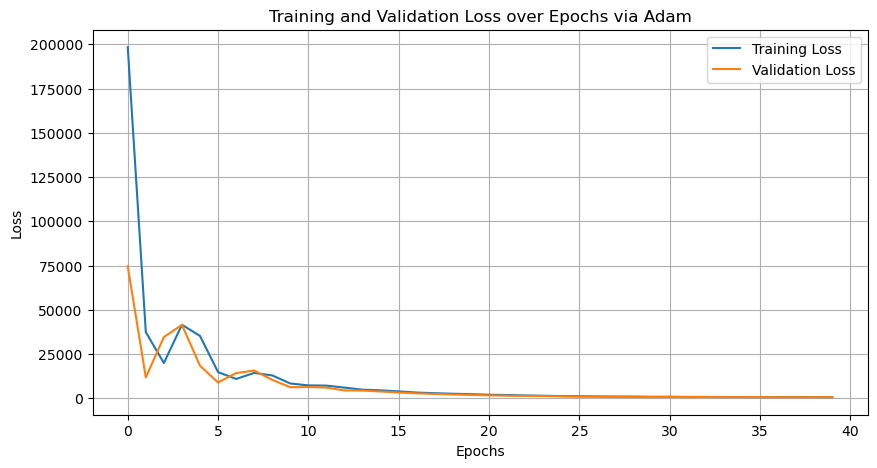

Train Epoch: 0 	 [Train Loss]: 647.380096 	 [Test Loss]: 642.154114
Train Epoch: 1 	 [Train Loss]: 648.766495 	 [Test Loss]: 614.769714
Train Epoch: 2 	 [Train Loss]: 644.119186 	 [Test Loss]: 612.214722
Train Epoch: 3 	 [Train Loss]: 626.900497 	 [Test Loss]: 642.890930
Train Epoch: 4 	 [Train Loss]: 616.932251 	 [Test Loss]: 615.821411
Train Epoch: 5 	 [Train Loss]: 631.871368 	 [Test Loss]: 615.133118
Train Epoch: 6 	 [Train Loss]: 644.216980 	 [Test Loss]: 579.136078
Train Epoch: 7 	 [Train Loss]: 643.461349 	 [Test Loss]: 650.627747
Train Epoch: 8 	 [Train Loss]: 628.908676 	 [Test Loss]: 608.512482
Train Epoch: 9 	 [Train Loss]: 646.554611 	 [Test Loss]: 563.853378


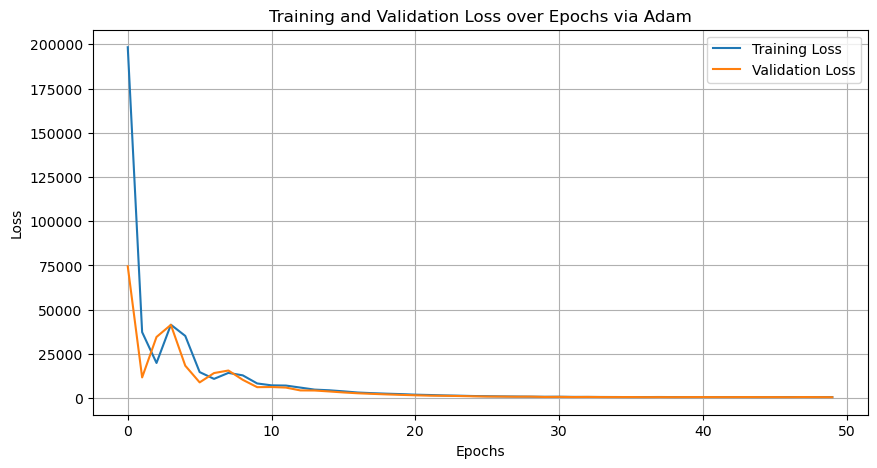

Train Epoch: 0 	 [Train Loss]: 641.161484 	 [Test Loss]: 630.417267
Train Epoch: 1 	 [Train Loss]: 643.153435 	 [Test Loss]: 605.394318
Train Epoch: 2 	 [Train Loss]: 639.304398 	 [Test Loss]: 602.528320
Train Epoch: 3 	 [Train Loss]: 621.285019 	 [Test Loss]: 631.398895
Train Epoch: 4 	 [Train Loss]: 611.086319 	 [Test Loss]: 612.388367


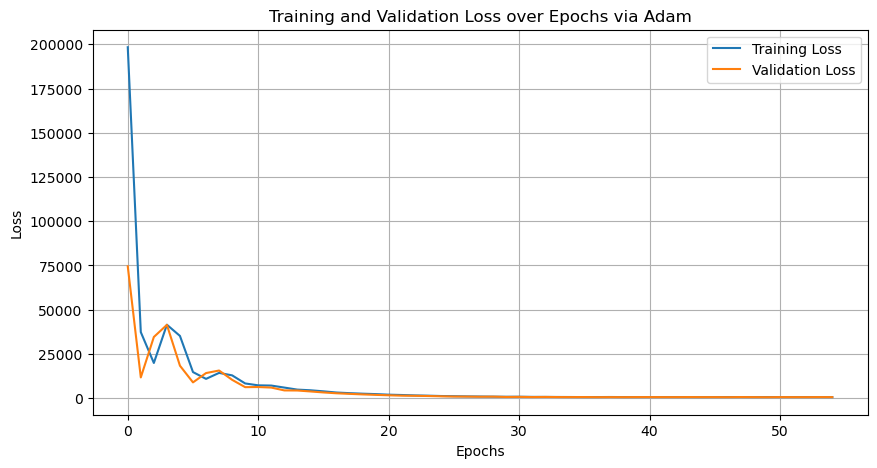

Train Epoch: 0 	 [Train Loss]: 95387.036377 	 [Test Loss]: 9998.317383
Train Epoch: 1 	 [Train Loss]: 9265.072998 	 [Test Loss]: 7055.156494
Train Epoch: 2 	 [Train Loss]: 7203.117188 	 [Test Loss]: 5848.508301
Train Epoch: 3 	 [Train Loss]: 6012.862061 	 [Test Loss]: 6547.853027
Train Epoch: 4 	 [Train Loss]: 4704.731812 	 [Test Loss]: 3382.026733
Train Epoch: 5 	 [Train Loss]: 3023.988037 	 [Test Loss]: 2267.525635
Train Epoch: 6 	 [Train Loss]: 2253.762207 	 [Test Loss]: 1906.070374
Train Epoch: 7 	 [Train Loss]: 1788.842316 	 [Test Loss]: 1709.394348
Train Epoch: 8 	 [Train Loss]: 1491.226990 	 [Test Loss]: 1366.027588
Train Epoch: 9 	 [Train Loss]: 1249.549622 	 [Test Loss]: 979.730743
Train Epoch: 10 	 [Train Loss]: 991.065109 	 [Test Loss]: 866.453033
Train Epoch: 11 	 [Train Loss]: 917.085403 	 [Test Loss]: 900.686157
Train Epoch: 12 	 [Train Loss]: 836.768982 	 [Test Loss]: 711.989227
Train Epoch: 13 	 [Train Loss]: 771.925705 	 [Test Loss]: 796.074280
Train Epoch: 14 	 [Train

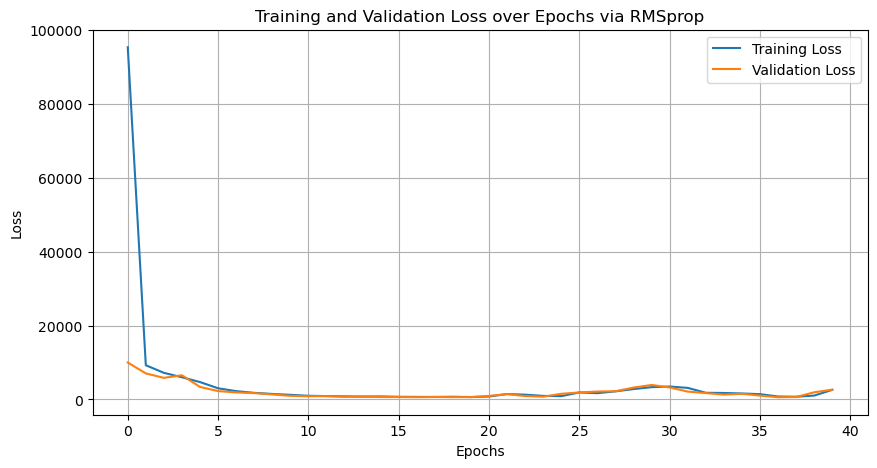

Train Epoch: 0 	 [Train Loss]: 3094.938293 	 [Test Loss]: 3595.482666
Train Epoch: 1 	 [Train Loss]: 4384.320679 	 [Test Loss]: 3339.713623
Train Epoch: 2 	 [Train Loss]: 2331.501556 	 [Test Loss]: 1623.884888
Train Epoch: 3 	 [Train Loss]: 1383.650253 	 [Test Loss]: 1005.929565
Train Epoch: 4 	 [Train Loss]: 833.700424 	 [Test Loss]: 660.364655
Train Epoch: 5 	 [Train Loss]: 749.505096 	 [Test Loss]: 782.790497
Train Epoch: 6 	 [Train Loss]: 870.986023 	 [Test Loss]: 1228.732727
Train Epoch: 7 	 [Train Loss]: 1472.554657 	 [Test Loss]: 2358.663696
Train Epoch: 8 	 [Train Loss]: 2044.973999 	 [Test Loss]: 2016.949280
Train Epoch: 9 	 [Train Loss]: 2846.440735 	 [Test Loss]: 2978.256836


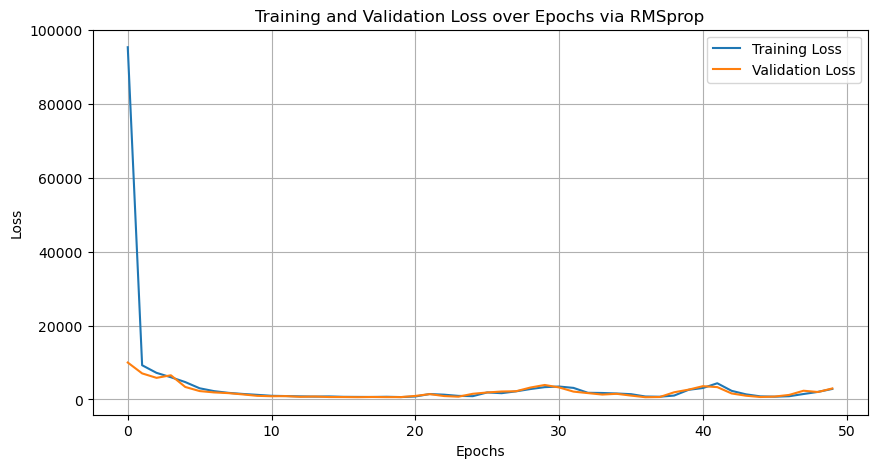

Train Epoch: 0 	 [Train Loss]: 3549.237549 	 [Test Loss]: 4070.418823
Train Epoch: 1 	 [Train Loss]: 4737.305908 	 [Test Loss]: 3384.898682
Train Epoch: 2 	 [Train Loss]: 2289.497925 	 [Test Loss]: 1499.406982
Train Epoch: 3 	 [Train Loss]: 1264.183685 	 [Test Loss]: 897.669159
Train Epoch: 4 	 [Train Loss]: 751.470169 	 [Test Loss]: 628.847717


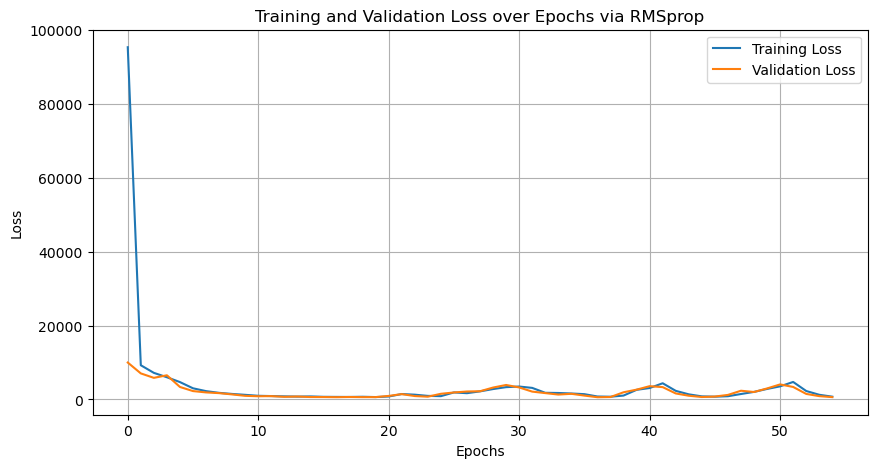

Best Optimizer: Adam
Best Epoch: 49
Best learning rate: 50


In [2600]:
train_res = {}
validation_res = {}
best_epochs = {}
models = {}

for optimizer_name, _ in optimizers.items():
    train_res[optimizer_name] = []
    validation_res[optimizer_name] = []

for optimizer_name, optimizer_func in optimizers.items():
    model_name = f'LinearRegression_{optimizer_name}'
    model = LinearRegression_torch(in_dim, out_dim)
    optimizer = optimizer_func(model.parameters(), lr=lr)

    for ind, epoch in enumerate(epochs):
        metrics = train_cycle(optimizer, model, epoch, model_name, sum(epochs[:ind]))
        train_res[optimizer_name] += metrics["train"]
        validation_res[optimizer_name] += metrics["test"]
        
        plot_metrics(sum(epochs[:ind]) + epoch, train_res[optimizer_name], validation_res[optimizer_name], optimizer_name)

    # Find the epoch with the best validation loss
    best_epoch = validation_res[optimizer_name].index(min(validation_res[optimizer_name]))
    best_epochs[optimizer_name] = best_epoch

    models[optimizer_name] = model
    del(model, optimizer)

best_optimizer = min(best_epochs, key=lambda k: validation_res[k][best_epochs[k]])
best_epoch = best_epochs[best_optimizer]

print(f"Best Optimizer: {best_optimizer}")
print(f"Best Epoch: {best_epoch}")
print(f"Best learning rate: {lr}")

In [2601]:
def clean_dir(dir_path: str):
    files = glob.glob(dir_path + "*")
    for f in files:
        os.remove(f)

In [2602]:
# Define the function to load the best model state
def load_best_model(epoch, optimizer_name):
    best_model = LinearRegression_torch(in_dim, out_dim)
    optimizer = optimizers[optimizer_name](best_model.parameters(), lr=lr)
    load_model_state(best_model, optimizer, f'LinearRegression_{optimizer_name}', epoch)
    return best_model, optimizer

# Load the best model and optimizer state
best_model, optimizer = load_best_model(best_epoch, best_optimizer)
_, train_loss, test_loss = load_model_state(best_model, optimizer, f'LinearRegression_{best_optimizer}', best_epoch)

clean_dir(model_states_dir)


print(f"Loaded model at epoch {best_epoch}, {best_optimizer} optimizer, {lr} learning rate with train loss {train_loss:.6f} and validation loss {test_loss:.6f}")

Loaded model at epoch 49, Adam optimizer, 50 learning rate with train loss 646.554611 and validation loss 563.853378


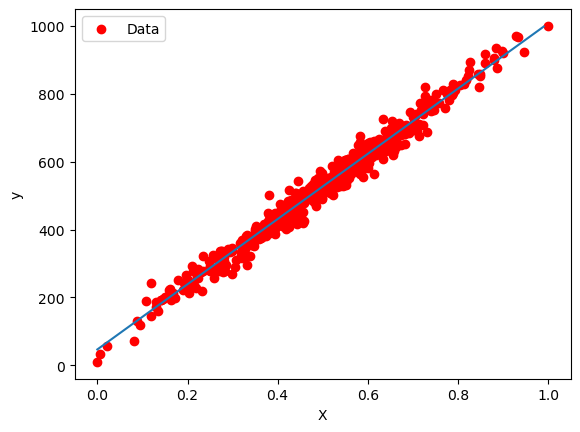

In [2603]:
graph(my_formula, x_range,  X, y, intercept=best_model.linear.bias.item(), coef=best_model.linear.weight.item())

#### I've noticed that learning rate values after 50 don't meaningfully impact performance that is difference is in range (1,2) as for MSE

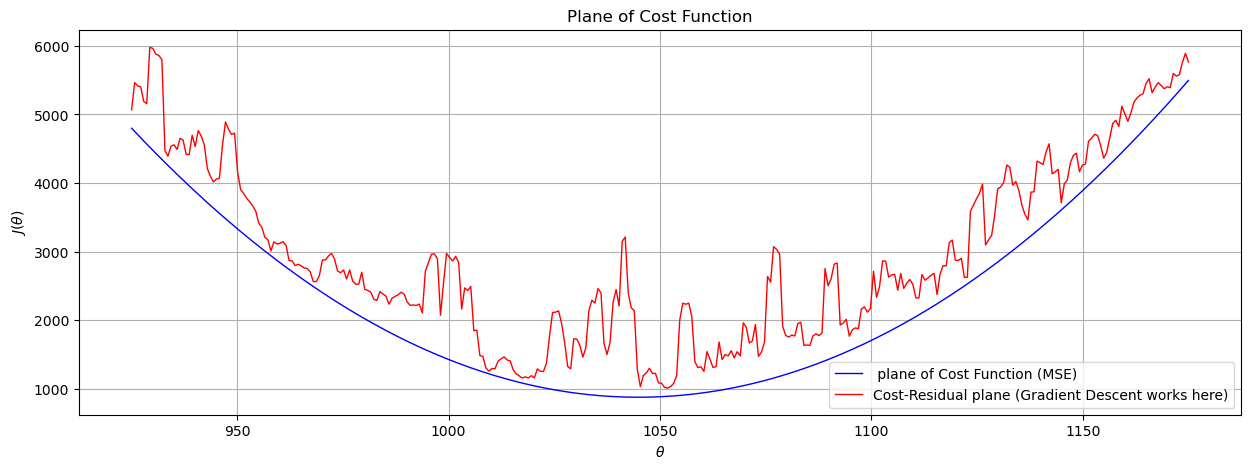

In [2604]:
# Creation of plot of Cost Function

# Cost function for a single parameter theta
def compute_cost(theta_1, x, y_true):
    n = len(y_true)
    y_pred = theta_1 * x
    cost = 1/n * np.sum(np.square(y_true - y_pred))

    return cost

# Moving average
def moving_average(data, window_size):
    pad_width = window_size // 2
    padded_data = np.pad(data, pad_width, mode = 'linear_ramp')
    windows = sliding_window_view(padded_data, window_size)
    moving_avg = np.mean(windows, axis = 1)

    if window_size % 2 == 0:
        return moving_avg[:-1]
    else:
        return moving_avg


x_len = x_train_torch.shape[0]

# Generate a range of values for theta_1
theta_vals = np.linspace(925, 1175, x_len)

# Compute the cost for each value of theta
J_vals = np.array([compute_cost(i, x_train_torch.numpy(), y_train_torch.numpy()) for i in theta_vals])

# Compute the residuals for each prediction
y_pred = best_model(x_train_torch.reshape(-1, 1)).detach().numpy()
res_vals = np.square(y_train_torch.numpy().reshape(-1, 1) - y_pred)
# Reshape residuals  into a vector
res_vals  =  res_vals.reshape(len( res_vals))
# Apply moving average to smooth the noise in residuals
smooth_res_vals = moving_average(res_vals, window_size = 5)

# Create plot
fig, ax = plt.subplots(1, 1, figsize = (15, 5))

# Plane of Cost Function
ax.plot(theta_vals, J_vals, label = ' plane of Cost Function (MSE)', color = 'blue', linewidth = 1)
# Plane of Cost Function and Residuals
ax.plot(theta_vals,  smooth_res_vals + J_vals, label = 'Cost-Residual plane (Gradient Descent works here)', color = 'red', linewidth = 1)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$J(\theta)$')
plt.title('Plane of Cost Function')
plt.grid(True, zorder = -1)
plt.legend()
plt.show()